In [2]:
#First part taken from the pyFAI tutorial
#https://pyfai.readthedocs.io/en/stable/usage/tutorial/Introduction/introduction.html
#####################################################
#Nota: May be used if you are behind a firewall and need to setup a proxy
import os
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"
import time
import numpy
start_time = time.perf_counter()
import pyFAI
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
print("Using pyFAI version", pyFAI.version)
import numpy as np
#initializes the visualization module to work with the jupyter notebook
%matplotlib inline
#Better user experience can be obtained with
# %matplotlib widget
from matplotlib.pyplot import subplots

c:\Users\Leo\anaconda3\envs\work\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


Using pyFAI version 2025.3.0


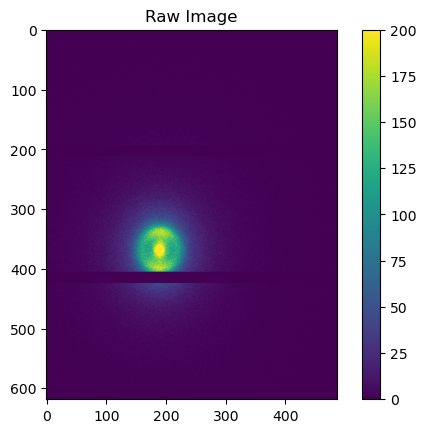

In [3]:
import fabio
from pyFAI.gui import jupyter
import matplotlib.pyplot as plt

# Load the image
img = fabio.open('5CNC0T_raw.tiff').data

# Set the minimum and maximum intensity values
vmin = 0  # minimum intensity value
vmax = 200  # maximum intensity value

# Display the image with specified intensity range
plt.imshow(img, vmin=vmin, vmax=vmax, cmap='viridis')
plt.title("Raw Image")
plt.colorbar()
plt.show()

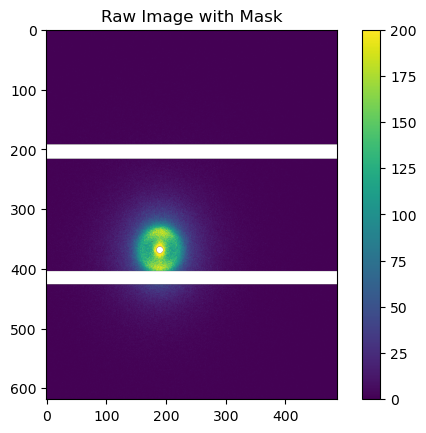

In [5]:
# Load the mask from an EDF file
# pygdatax_gui was used to draw the mask
mask_file = '5CNCmask.edf'
mask = fabio.open(mask_file).data

# Display the image with the mask applied
vmin = 0  # minimum intensity value
vmax = 200  # maximum intensity value
plt.imshow(np.ma.masked_array(img, mask),vmin=vmin, vmax=vmax, cmap='viridis')

plt.title("Raw Image with Mask")
plt.colorbar()
plt.show()

In [6]:
import pyFAI, pyFAI.detectors


# Use the specific detector class for PILATUS3 300
detector = pyFAI.detectors.Pilatus300k()
detector.mask = mask


# Method 2 to create mask. 
#mask = np.zeros(detector.shape, dtype=bool)
#mask = (img > 300) | (img <0.00010)


# Create an AzimuthalIntegrator with the detector
ai = AzimuthalIntegrator(detector=detector)
ai.wavelength = 1.542e-10  # 1.54 angstroms in meters
ai.setFit2D(1530.4453, 189.783, 368.952)

print(ai)


Detector Pilatus 300k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.542000e-10 m
SampleDetDist= 1.530445e+00 m	PONI= 6.345974e-02, 3.264268e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1530.445 mm	Center: x=189.783, y=368.952 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.542Å


Text(0, 0.5, 'Intensity')

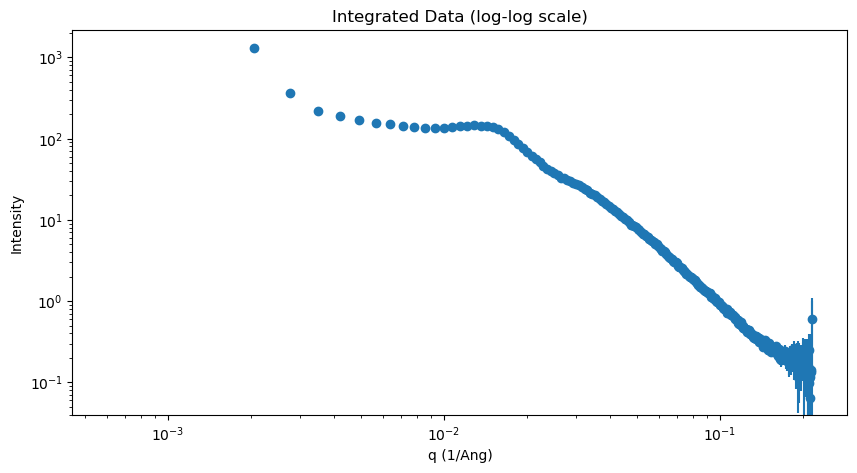

In [7]:
# Integrate with units in inverse angstroms, applying the mask
res= ai.integrate1d_ng(img, 300, unit="q_A^-1", mask=mask, method="cython", error_model="poisson")

# Display the integration result 
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(res.radial, res.intensity, yerr=res.sigma, fmt='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Integrated Data (log-log scale)")
ax.set_xlabel("q (1/Ang)")
ax.set_ylabel("Intensity")


<Axes: title={'center': '2D regrouping'}, xlabel='Scattering vector $q$ ($\\AA^{-1}$)', ylabel='Azimuthal angle $\\chi$ ($^{o}$)'>

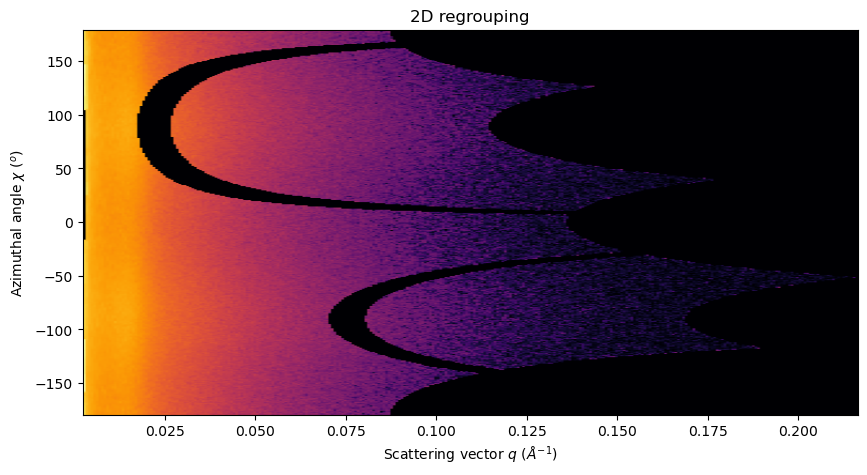

In [ ]:
# Integrate with units in inverse angstroms and specified q limits, applying the mask.
# Not sure if the mask is actually being applied. image looks the same without it
res= ai.integrate2d_ng(img, 300, unit="q_A^-1", mask=mask)

# Display the integration result 
fig, ax = plt.subplots(figsize=(10, 5))
jupyter.plot2d(res, ax=ax)


Added option for radial integration and azimuthal integration by different sectors.

Column number 11


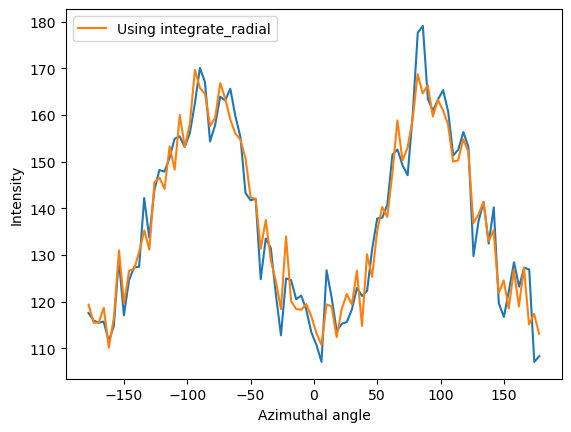

In [10]:
target = 0.01 #angstrom-1

I, tth, chi = ai.integrate2d_ng(img, 300, 90, unit="q_A^-1", mask=mask)
column = numpy.argmin(abs(tth-target))
print("Column number %s"%column)

fig, ax = subplots()
ax.plot(chi, I[:,column])
ax.set_xlabel("Azimuthal angle")
ax.set_ylabel("Intensity")
ax.plot(*ai.integrate_radial(img, 90, radial_range=(0.009, 0.011), radial_unit="q_A^-1", mask =mask,
                             method=("no", "histogram", "cython")), 
        label="Using integrate_radial")
ax.legend()
pass

Column number for target 0.01: 11
Column number for target 0.015: 18
Column number for target 0.02: 25
Column number for target 0.03: 39


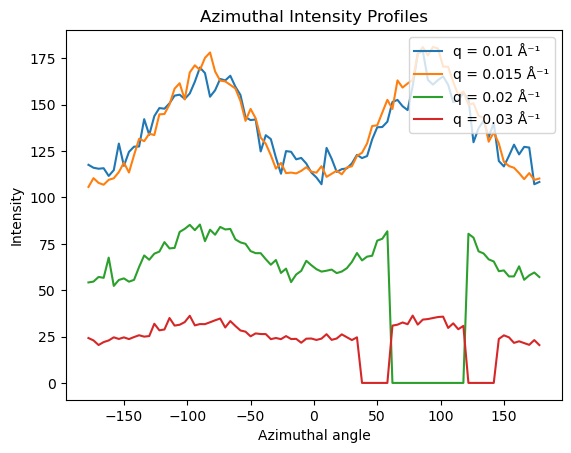

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

targets = [0.01, 0.015, 0.02, 0.03]  # angstrom-1

# Perform 2D integration
I, tth, chi = ai.integrate2d_ng(img, 300, 90, unit="q_A^-1", mask=mask)

# Create a DataFrame to store azimuthal profiles
df = pd.DataFrame({'Azimuthal Angle (chi)': chi})

for current_target in targets:
    # Find the column corresponding to the current target
    column = np.argmin(abs(tth - current_target))
    print(f"Column number for target {current_target}: {column}")
    
    # Add the azimuthal intensity profile as a column in the DataFrame. name of column is q = target
    df[f"q = {current_target} Å⁻¹"] = I[:, column]

# Plot all profiles on the same graph
fig, ax = plt.subplots()
for current_target in targets:
    ax.plot(df['Azimuthal Angle (chi)'], df[f"q = {current_target} Å⁻¹"], label=f"q = {current_target} Å⁻¹")

# Add labels, legend, and title
ax.set_xlabel("Azimuthal angle")
ax.set_ylabel("Intensity")
ax.set_title("Azimuthal Intensity Profiles")
ax.legend(loc='upper right')

# Show the plot
plt.show()



c:\Users\Leo\anaconda3\envs\work\Lib\site-packages\pyFAI\integrator\azimuthal.py:615: RuntimeWarning: invalid value encountered in divide
  intensity = sum_signal / sum_normalization


Text(0, 0.5, 'Intensity')

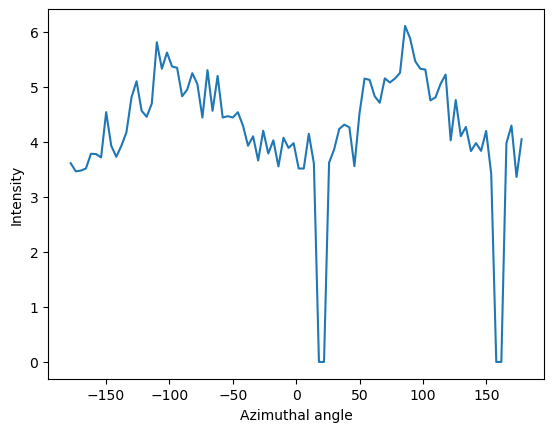

In [58]:
chi, I = ai.integrate_radial(img, 90, radial_range=(0.06, 0.062), radial_unit="q_A^-1", mask =mask,
                             method=("no", "histogram", "cython"))

plt.plot(chi, I)
plt.xlabel("Azimuthal angle")   
plt.ylabel("Intensity")

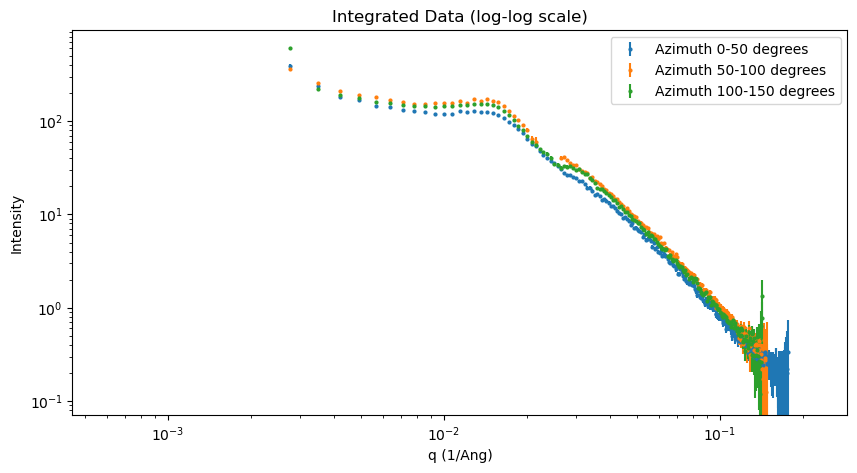

In [65]:
# Integrate with units in inverse angstroms, applying the mask
azimuth_range = [(0, 50), (50, 100), (100, 150)]


fig, ax = plt.subplots(figsize=(10, 5))
for azimuth in azimuth_range:
    res = ai.integrate1d_ng(img, 300, unit="q_A^-1", azimuth_range=azimuth, mask=mask, method="cython", error_model="poisson")
    
    # Display the integration result 
    
    ax.errorbar(res.radial, res.intensity, yerr=res.sigma, fmt='o', markersize= 2, label=f"Azimuth {azimuth[0]}-{azimuth[1]} degrees")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Integrated Data (log-log scale)")
ax.set_xlabel("q (1/Ang)")
ax.set_ylabel("Intensity")

ax.legend(loc='upper right')

# Show the plot
plt.show()
